In [2]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import seaborn
#import transformers
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from inspect import signature as sgn
dirr = lambda x : [i for i in x if i[0]!='_']

df = pd.read_feather("data/final/text/embeds")

target_col = ['SD','QE','SV','PR','HD']

df['none'] = (df[target_col].sum(axis=1)==0).astype('int64')

#target_col.append('none')

features_col = [str(x) for x in range(768)]

scaler = StandardScaler()
to_pca = scaler.fit_transform(df[features_col])

pca = PCA(n_components=0.99)

pca_ed = pca.fit_transform(to_pca)

pca_col = [str(x) for x in range(768,768+pca_ed.shape[1])]

df[pca_col] = pca_ed

none_index    = df.loc[df.none==1].index#sample(1000, random_state=1).index
labeled_index = df.loc[df.none==0].index

dataframe = df.loc[labeled_index.union(none_index)]

df.head(1)

/var/folders/hy/zqxlyfbn7zg8yjx6twjrxslr0000gn/T/ipykernel_44908/2848685932.py:37: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[pca_col] = pca_ed
/var/folders/hy/zqxlyfbn7zg8yjx6twjrxslr0000gn/T/ipykernel_44908/2848685932.py:37: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[pca_col] = pca_ed
/var/folders/hy/zqxlyfbn7zg8yjx6twjrxslr0000gn/T/ipykernel_44908/2848685932.py:37: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Cons

,Dyad,Session,begin_time,end_time,duration,utt,speaker,SD,QE,SV,...,1195,1196,1197,1198,1199,1200,1201,1202,1203,1204
0,6,1,0 days 00:00:12.088000,0 days 00:00:15.891000,0 days 00:00:03.803000,okay pause filler well hi,1,0,0,0,...,-0.370988,-0.024552,0.329781,0.114036,0.311514,0.168424,0.584182,-0.103394,0.010036,0.041064


In [3]:
%%timeit
torch.from_numpy(df[features_col].values)

2.41 ms ± 23.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [4]:
X_train, X_test, y_train, y_test = map(lambda x: torch.from_numpy(x.values).type(torch.float32) , train_test_split( dataframe[features_col], dataframe[target_col], train_size=.7, random_state=1))
train_set = TensorDataset( X_train, y_train )
test_set = TensorDataset( X_test, y_test )

In [5]:
# Construct our winning model
class Model(nn.Module):
    
    def __init__(self, input_size=768, output_size=5):
        super(Model, self).__init__()
        
        self.sec = nn.Sequential(
            nn.Linear(input_size, 100, dtype=torch.float32),
            nn.ReLU(),
            #nn.Linear(100, 100, dtype=torch.float32),
            #nn.ReLU(),
            nn.Linear(100, output_size, dtype=torch.float32),
            nn.Sigmoid(),
        )

    def forward(self, inputs):
        return self.sec(inputs)

In [6]:
def train(num_epochs, batch_size, criterion, optimizer, model, train_set, test_set):

    dataloader = DataLoader(train_set, batch_size, shuffle=True)

    #model = model.to(device)
    model.train()

    train_loss=[]
    test_loss=[]

    for epoch in range(num_epochs):

        epoch_average_loss = 0.0

        model.train()
        for (X, y) in (dataloader):


            #X = X.to(device)
            #y = y.to(device)

            y_pre = model(X)

            loss = criterion(y_pre, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_average_loss += loss.item() * batch_size / len(train_set)

        train_loss.append(epoch_average_loss)

        model.eval()
        with torch.no_grad():
            y_pre_val = model(test_set.tensors[0])
        test_loss.append(criterion(y_pre_val, test_set.tensors[1]).float().item())

    return train_loss, test_loss

def train_eval(model, train_set, test_set ,num_epochs = 4, batch_size = 10 ,lr=0.01):

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    y_test = test_set.tensors[1]

    class_weights = y_test.sum(dim=0) / y_test.shape[0]

    criterion = nn.CrossEntropyLoss()

    train_loss, test_loss = train(num_epochs, batch_size, criterion, optimizer, model, train_set, test_set)

    # Calculate mean squared error on validation set
    model.eval()
    with torch.no_grad():
        y_pre_val = model(test_set.tensors[0])
    error = criterion(y_pre_val, y_test).float().item()
    print(f'The loss on validation set is: {error:.4f}')

    return train_loss, test_loss

def make_heat_map(y_test,pred_n):
    cm = pd.DataFrame(columns=pd.Series(target_col,name='Predicted'),index=pd.Series(target_col,name='True')).fillna(0)
    for (x,y) in zip(y_test.argmax(dim=1).numpy(),pred_n.argmax(axis=1)):
        cm.iloc[x,y]+=1
    seaborn.heatmap(cm, annot=True)
    plt.show()

def pipeline(model,num_epochs = 300, batch_size = 40 ,lr=0.0001, tresh=.9):
    train_loss, test_loss = train_eval(model, train_set, test_set,num_epochs, batch_size,lr)

    plt.plot(train_loss, label='Train')
    plt.plot(test_loss, label='Test')
    plt.legend()
    plt.show()
    model.eval()
    pred_n = model(X_test).detach().numpy()
    print(classification_report(y_test.detach().numpy(),np.where(pred_n>.9,1,0)))
    make_heat_map(y_test,pred_n)

The loss on validation set is: 0.1128


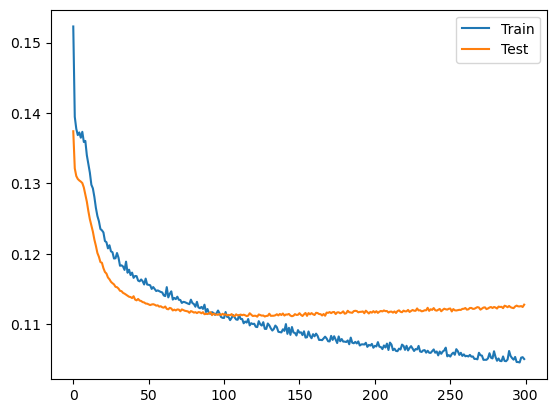

              precision    recall  f1-score   support

           0       0.13      0.82      0.23       133
           1       0.12      0.80      0.21        25
           2       0.00      0.00      0.00         6
           3       0.10      0.56      0.17        16
           4       0.07      0.78      0.13       128

   micro avg       0.10      0.77      0.17       308
   macro avg       0.09      0.59      0.15       308
weighted avg       0.10      0.77      0.18       308
 samples avg       0.07      0.08      0.07       308



/Users/tancredeasselot/miniconda/envs/projet_ewen/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/tancredeasselot/miniconda/envs/projet_ewen/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/tancredeasselot/miniconda/envs/projet_ewen/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_pr

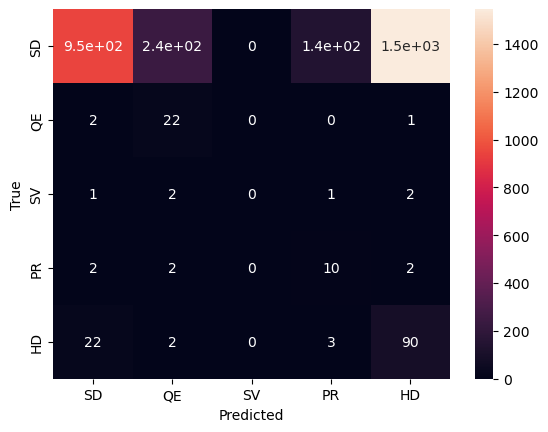

In [7]:
model = Model()
pipeline(model,num_epochs = 300, batch_size = 40 ,lr=0.0001, tresh=.94)

In [1]:
    model.eval()
    pred_n = model(X_test).detach().numpy()
    print(classification_report(y_test.detach().numpy(),np.where(pred_n>.9,1,0)))

NameError: name 'model' is not defined

In [ ]:
X_train, X_test, y_train, y_test = map(lambda x: torch.from_numpy(x.values).type(torch.float32) , train_test_split( dataframe[pca_col], dataframe[target_col], train_size=.7, random_state=1))
train_set = TensorDataset( X_train, y_train )
test_set = TensorDataset( X_test, y_test )

The loss on validation set is: 0.6296


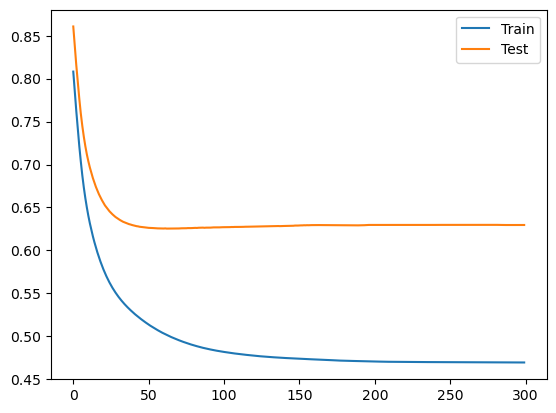

0.8399572101053178
              precision    recall  f1-score   support

           0       0.55      0.73      0.63       137
           1       0.67      0.64      0.65        22
           2       0.00      0.00      0.00        14
           3       0.50      0.44      0.47        16
           4       0.39      0.73      0.51       140

   micro avg       0.47      0.68      0.55       329
   macro avg       0.42      0.51      0.45       329
weighted avg       0.47      0.68      0.54       329
 samples avg       0.36      0.36      0.36       329



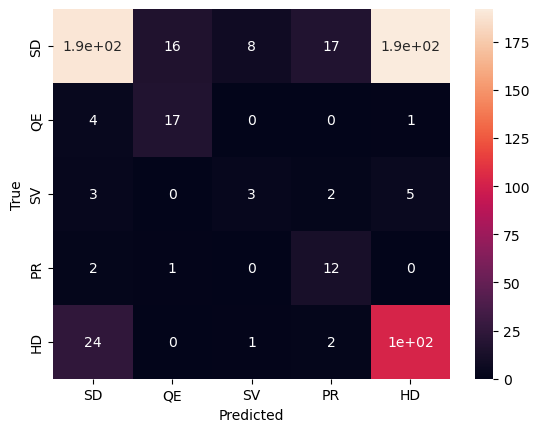

In [ ]:
model = Model(input_size=X_train.shape[1])
pipeline(model,num_epochs = 300, batch_size = 40 ,lr=0.0001, tresh=.94)

In [ ]:
clf = RandomForestClassifier().fit(X_train.detach().numpy(), y_train.detach().numpy())

print(classification_report(y_test.detach().numpy(), clf.predict(X_test.detach().numpy())))

              precision    recall  f1-score   support

           0       0.57      0.03      0.06       137
           1       1.00      0.05      0.09        22
           2       0.00      0.00      0.00        14
           3       1.00      0.19      0.32        16
           4       1.00      0.01      0.01       140

   micro avg       0.75      0.03      0.05       329
   macro avg       0.71      0.05      0.09       329
weighted avg       0.78      0.03      0.05       329
 samples avg       0.01      0.01      0.01       329



In [563]:
from focal_loss.focal_loss import FocalLoss

# Withoout class weights
criterion = FocalLoss(gamma=0.7)

# with weights 
# The weights parameter is similar to the alpha value mentioned in the paper
weights = torch.FloatTensor([2, 3.2, 0.7])
criterion = FocalLoss(gamma=0.7, weights=weights)

# to ignore index 
criterion = FocalLoss(gamma=0.7, ignore_index=0)

# To make it behaves as CrossEntropy loss
criterion = FocalLoss(gamma=0)